# Learning a Nonlinear Damping Model
> ©2024 Nathan Albin, Andrew Bennett, Abhinav Chand

In [1]:
# install a Python package we need
!pip install torchdiffeq

In [2]:
# import Python packages we'll need
#

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
torch.set_default_dtype(torch.float64)

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint

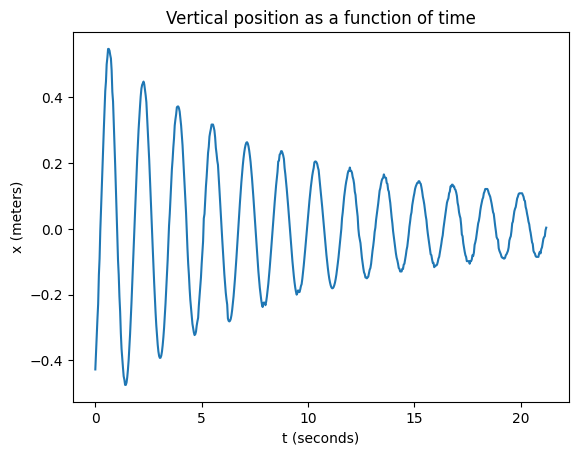

In [3]:
# measured mass (in grams)
m = 537

# location of the data file
data_url = 'https://raw.githubusercontent.com/nathan-albin/mass-spring-neural-ode/refs/heads/main/data.csv'

# load the data file
df = pd.read_csv(data_url)

# extract the time and (vertical) position data
t = df['time'].to_numpy()
x = df['vertical'].to_numpy()/100  # convert centimeters to meters

# plot the data
plt.plot(t, x)
plt.xlabel('t (seconds)')
plt.ylabel('x (meters)')
plt.title('Vertical position as a function of time');

# Linear model

$$
x(t) = Ae^{-pt}\cos(\omega_1t-\gamma) + \alpha.
$$

The parameter $\alpha$ is the rest position of the system.

In [4]:
class DecayingSinusoid(nn.Module):
    '''
    Implements a decaying sinusoidal model.
    '''

    def __init__(self):
        '''
        Initialize the model.
        '''
        super().__init__()

        self.A = nn.Parameter(torch.randn(1))           # amplitude
        self.rp = nn.Parameter(1e-8*torch.randn(1))     # square root of the parameter p
        self.w1 = nn.Parameter(torch.randn(1))          # angular frequency
        self.gamma = nn.Parameter(1e-3*torch.randn(1))  # phase offset
        self.alpha = nn.Parameter(1e-6*torch.randn(1))  # rest position

    def forward(self, t):
        '''
        Evaluate the model at time t.
        '''
        return self.A*torch.exp(-self.rp**2*t)*torch.cos(self.w1*t-self.gamma) + self.alpha

In [5]:
# ensure reproducibility
torch.manual_seed(389199281)

# create the model
model = DecayingSinusoid()

# convert time and position to PyTorch tensors
tt = torch.tensor(t)
xx = torch.tensor(x)

# create an Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-1)

# perform gradient descent
for itr in range(1, 1001):

    optimizer.zero_grad()
    x_hat = model(tt)
    loss = F.mse_loss(x_hat, xx)
    loss.backward()
    optimizer.step()

    # output status periodically
    if itr % 100 == 0:
        print(f'iteration {itr:5d}   loss {loss:.3e}')

iteration   100   loss 3.474e-02
iteration   200   loss 3.446e-02
iteration   300   loss 3.417e-02
iteration   400   loss 3.348e-02
iteration   500   loss 3.180e-02
iteration   600   loss 2.602e-02
iteration   700   loss 2.366e-04
iteration   800   loss 2.351e-04
iteration   900   loss 2.351e-04
iteration  1000   loss 2.351e-04


Learned Parameters
  A      = -0.538
  p      = 0.095
  w1     = 3.885
  gamma  = -0.651
  alpha  = 7.874e-03

Inferred Parameters
  w0 = 3.886
  k  = 8108.712
  c  = 101.620



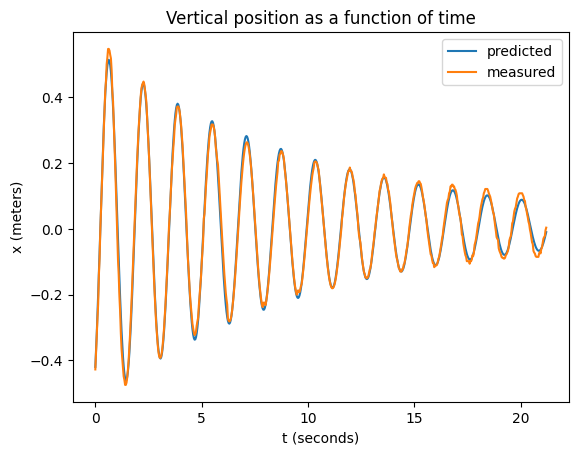

In [6]:
# plot the model and data
plt.plot(t, x_hat.detach(), label='predicted')
plt.plot(t, x, label='measured')
plt.xlabel('t (seconds)')
plt.ylabel('x (meters)')
plt.title('Vertical position as a function of time')
plt.legend()

# get the learned parameters
A = model.A.detach().numpy()[0]
p = model.rp.detach().numpy()[0]**2
w1 = model.w1.detach().numpy()[0]
gamma = model.gamma.detach().numpy()[0]
alpha = model.alpha.detach().numpy()[0]

print('Learned Parameters')
print(f'  A      = {A:.3f}')
print(f'  p      = {p:.3f}')
print(f'  w1     = {w1:.3f}')
print(f'  gamma  = {gamma:.3f}')
print(f'  alpha  = {alpha:.3e}')
print()

# natural angular frequency
w0 = np.sqrt(w1**2 + p**2)

# spring constant
k = w0**2*m

# damping coefficient
c = 2*m*p

print('Inferred Parameters')
print(f'  w0 = {w0:.3f}')
print(f'  k  = {k:.3f}')
print(f'  c  = {c:.3f}')
print()

# Nonlinear model

$$
\begin{cases}
    x' = v \\
    v' = -\frac{f(v)}{m} - \frac{k}{m}(x-\alpha)
\end{cases}
$$

The parameters $k$ and $\alpha$ are initialized with their learned values from the linear model and are allowed to vary during training. The function $f(v)$ is a perturbation of the linear model:
$$
f(v) = c(1 + \tilde{f}(v))v,
$$
where $\tilde{f}(v)$ is a neural network. The parameter $c$ is initialized with the value from the linear model and allowed to vary during training.

In [7]:
class NonlinearDampingModel(nn.Module):
    '''
    Implements a nonlinear damped spring-mass system.
    '''

    def __init__(self, m, c, k, alpha):
        '''
        Initialize the model.
        '''
        super().__init__()

        self.m = m                                         # the mass
        self.c = nn.Parameter(torch.tensor(c))             # the damping coefficient
        self.rk = nn.Parameter(torch.tensor(np.sqrt(k)))   # the spring constant
        self.alpha = nn.Parameter(torch.tensor(alpha))     # the rest position

        # the neural network for f-tilde
        self.damping_layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )

    def damping(self, v):
        '''
        Evaluate the damping function.
        '''
        return self.c*(1 + self.damping_layers(v))*v

    def forward(self, t, vars):
        '''
        Evaluate the model at time t and state vars = (x,v).
        '''

        # get model parameters
        m, c, alpha = self.m, self.c, self.alpha
        k = self.rk**2

        # unpack the state variables
        x, v = vars

        # compute the damping
        damp = self.damping(v.reshape([-1,1]))

        # compute the derivatives
        dx = v
        dv = -damp[0,0]/m - k/m*(x-alpha)

        # return the derivatives as a torch tensor
        return torch.stack([dx, dv])

In the code cell below, you can either set `train_model = True` to train the model yourself (this will take about 5 minutes), or use `train_model = False` to load the pretrained model.

In [8]:
# set the following to True if you want to train the model
# set it to False if you want to load a pretrained model
train_model = False

# location of the model file
data_url = 'https://github.com/nathan-albin/mass-spring-neural-ode/raw/refs/heads/main/model.pt'

# initial conditions from the data
x0 = torch.tensor(x[0])
v0 = torch.tensor((x[1]-x[0])/(t[1]-t[0]))
X0 = torch.stack([x0,v0])

# train the model if desired
if train_model:

    # ensure reproducibility
    torch.manual_seed(389199281)

    # the model to train
    model = NonlinearDampingModel(m, c, k, alpha)

    # create an Adam optimizer
    optimizer = optim.Adam(list(model.parameters()), lr=1e-2)

    # perform gradient descent
    for itr in range(1, 51):

        optimizer.zero_grad()
        x_hat = odeint(model, X0, tt, method='rk4')
        loss = F.mse_loss(x_hat[:,0], xx)
        loss.backward()
        optimizer.step()

        # output status periodically
        if itr % 5 == 0:
            print(f'iteration {itr:5d}   loss {loss:.3e}')

    # save the trained model
    torch.save(model.state_dict(), 'model.pt')

# otherwise, we need to download the pretrained model
else:
    model = NonlinearDampingModel(m, c, k, alpha)
    model.load_state_dict(torch.hub.load_state_dict_from_url(data_url))
    print('Model loaded.')

Downloading: "https://github.com/nathan-albin/mass-spring-neural-ode/raw/refs/heads/main/model.pt" to /root/.cache/torch/hub/checkpoints/model.pt
100%|██████████| 37.1k/37.1k [00:00<00:00, 836kB/s]

Model loaded.


Learned Parameters
  k      = 8072.451
  alpha  = 9.250e-03



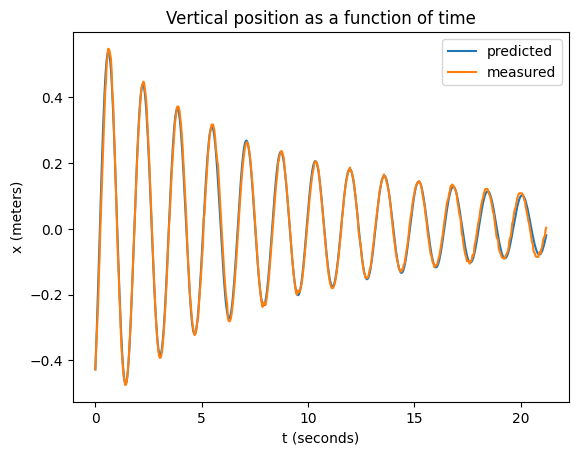

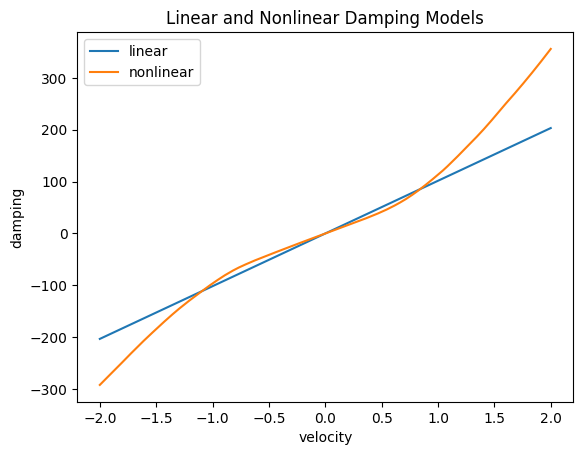

In [9]:
# solve the model ODE
x_hat = odeint(model, X0, tt, method='rk4')

# plot the model and data
plt.plot(t, x_hat.detach()[:,0], label='predicted')
plt.plot(t, x, label='measured')
plt.xlabel('t (seconds)')
plt.ylabel('x (meters)')
plt.title('Vertical position as a function of time')
plt.legend()

# plot the damping function
plt.figure()
v = torch.linspace(-2, 2, 1000).reshape([-1,1])
plt.plot(v, 0*v + c*v.detach().numpy(), label='linear')
plt.plot(v, model.damping(v).detach(), label='nonlinear')
plt.xlabel('velocity')
plt.ylabel('damping')
plt.title('Linear and Nonlinear Damping Models')
plt.legend()

# get the learned parameters
k = model.rk.detach().numpy()**2
alpha = model.alpha.detach().numpy()

print('Learned Parameters')
print(f'  k      = {k:.3f}')
print(f'  alpha  = {alpha:.3e}')
print()